# Import Packages

In [1]:
import csv
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import sqlite3
import seaborn as sns
from pandasql import sqldf
import numpy as np

# Review Data Available for Movie Genre/Box Office Success

It looks like first going into the IM.DB database is a good way to see what movies are in our dataset

In [2]:
conn = sqlite3.connect('../Data/im.db')

Looking at how to access all tables/table names

In [3]:
pd.read_sql('''
SELECT
    *
FROM
    sqlite_master

''',conn)

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


After looking at the ERD, it looks like financial data is going to have to come from the movie budgets csv. For our metric of box office success, we want to use profit and return on investment (ROI) to best choose our type of movie.

We could potentially use critic score from the ratings data table in IMDB if we wanted our studio to be known for producing critically acclaimed films that could win an award, but as a new studio, our execs are likely more worried about financials until their budget is large enough to take risks.

In [4]:
tnmovie = pd.read_csv('../Data/tn.movie_budgets.csv')

In [5]:
tnmovie.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


# Cleaning the movie budget csv to use numerical data

Additionally, addding a profit and a percent return (ROI) column

In [6]:
tnmovie['worldwide_gross'] = tnmovie['worldwide_gross'].str.replace("\$|,|\.", '', regex = True).astype('int64')

tnmovie['domestic_gross'] = tnmovie['domestic_gross'].str.replace("\$|,|\.", '', regex = True).astype('int64')

tnmovie['production_budget'] = tnmovie['production_budget'].str.replace("\$|,|\.", '', regex = True).astype('int64')

tnmovie['profit'] = tnmovie['worldwide_gross'] - tnmovie['production_budget']

tnmovie['perc_return'] = (tnmovie['profit'] / tnmovie['production_budget']) * 100

In [7]:
tnmovie.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit,perc_return
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2351345279,553.257713
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875,154.667286
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,-200237650,-57.210757
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,1072413963,324.384139
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,999721747,315.369636


In [8]:
tnmovie = tnmovie.sort_values(by='profit',
                   ascending=False)

In [9]:
tnmovie.shape

(5782, 8)

# Creating a Movie Basics dataframe from the IM.DB Database to grab movie genres

In [10]:
moviebasics = pd.read_sql('''
SELECT
    primary_title,
    genres
FROM
    movie_basics
WHERE
    primary_title = original_title

''',conn)

In [11]:
moviebasics.head()

,primary_title,genres
0,Sunghursh,"Action,Crime,Drama"
1,The Other Side of the Wind,Drama
2,Sabse Bada Sukh,"Comedy,Drama"
3,A Thin Life,Comedy
4,Bigfoot,"Horror,Thriller"


# Creating a grouped dataframe to pull in genres w/ budget

# Creating a new clean dataframe with just film title, genres,production_budget, worldwide_gross, and profit

First, creating a new grouped dataframe with duplicate movies to not lose any genres,
Then removing rows with null values in genres

In [12]:
genres = pd.merge(moviebasics,
                  tnmovie,
                  left_on='primary_title',
                  right_on='movie')

genres.dropna(subset=['genres'],
             inplace=True)

Now, updating the genres dataframe into a new, smaller dataframe with only pertinent columns

In [13]:
genres_clean = genres.filter(['primary_title', 'genres', 'production_budget', 'worldwide_gross', 'profit', 'perc_return'], axis=1)


In [14]:
genres_clean.shape

(3381, 6)

Quick check to see which movies have a large ROI

In [15]:
genres_clean.sort_values(by='perc_return',
                        ascending=False)

,primary_title,genres,production_budget,worldwide_gross,profit,perc_return
2306,The Gallows,"Horror,Mystery,Thriller",100000,41656474,41556474,41556.474000
2540,Bambi,"Biography,Documentary",858000,268000000,267142000,31135.431235
2789,Night of the Living Dead,Horror,114000,30087064,29973064,26292.161404
2685,Rocky,"Action,Comedy,Drama",1000000,225000000,224000000,22400.000000
2686,Rocky,"Action,Drama,Romance",1000000,225000000,224000000,22400.000000
...,...,...,...,...,...,...
2271,Forsaken,Horror,18000000,0,-18000000,-100.000000
3204,Bright,"Action,Crime,Fantasy",90000000,0,-90000000,-100.000000
2272,Forsaken,Thriller,18000000,0,-18000000,-100.000000
2273,Forsaken,Fantasy,18000000,0,-18000000,-100.000000


It appears that the top ROI movies didn't necessarily have large budgets, leading to an outsized ROI. Some of these movies may have such a large global gross due to cult status or nostalgia (Cinderella, Rocky, Bambi). We want a fan following, but we don't want to risk selection of genre that may not be successful (at large).

Additionally, the data frame has duplicate rows (all values same).

Next step cleans for complete duplicates, and filters down to only include movies with a global gross over 152,962,083 (the revenue of the 1000th top grossing movie).

This way, our dataframe will suggest the genre to use for a movie if the studio wants to produce a top 1000 movie (by worldwide gross, the biggest metric used by the public) and what the genre should be to get a strong ROI.

In [16]:
top_grossing = tnmovie.sort_values(by='worldwide_gross',
                   ascending=False)

In [17]:
top_grossing.iloc[999]

id                              100
release_date           Oct 14, 2016
movie                The Accountant
production_budget          40000000
domestic_gross             86260045
worldwide_gross           152962083
profit                    112962083
perc_return                 282.405
Name: 1399, dtype: object

It appears that the top ROI movies didn't necessarily have large budgets, leading to an outsized ROI. 

Some of these movies may have such a large global gross due to cult status or nostalgia (Cinderella, Rocky, Bambi). We want a fan following, but we don't want to risk selection of genre that may not be successful (at large).

Additionally, the data frame has duplicate rows (all values same) - we can drop these duplicates as it won't impact understanding the financials or the genre type.

Next step cleans for complete duplicates, and filters down to only include movies with a global gross over 152,962,083 (the revenue of the 1000th top grossing movie).

This way, our dataframe will suggest the genre to use for a movie if the studio wants to produce a top 1000 movie (by worldwide gross, the biggest metric used by the public) and what the genre should be to get a strong ROI.

In [18]:
genres_clean.drop_duplicates(keep='first',
                            inplace=True)

In [19]:
genres_clean.shape

(3202, 6)

In [20]:
genres_clean = genres_clean.loc[genres_clean['worldwide_gross'] >= 152962083]

In [21]:
genres_clean.sort_values(by='perc_return',
                   ascending=False,
                   inplace=True)

In [22]:
genres_clean.shape

(562, 6)

By filtering the genres_clean dataframe to only inlcude movies that have grossed in the top 100 worldwide, our dataframe has shrunk to only 561 records

# With a clean dataframe of movies and genres, create a new dataframe with Booleans for whether the movie has a certain genre

First create a new dataframe of just name, perc_return, and genre to use for analysis

In [23]:
genres_final = genres_clean.filter(['primary_title', 'genres', 'perc_return'], axis=1)

Next, use a lambda to concatenate the genres by title so we only have one record per title

In [24]:
genres_final['genres'] = genres_clean.groupby(['primary_title'])['genres'].transform(lambda x : ','.join(x))
  
# drop duplicate data
genres_final = genres_final.drop_duplicates(keep='first')   

In [25]:
genres_final.head(15)

,primary_title,genres,perc_return
2540,Bambi,"Biography,Documentary",31135.431235
2686,Rocky,"Action,Drama,Romance,Action,Comedy,Drama",22400.000000
3386,Snow White and the Seven Dwarfs,"Animation,Family,Comedy,Drama,Fantasy",12327.788038
218,Cinderella,"Drama,Family,Fantasy,Comedy,Fantasy,Drama,Fant...",8989.359138
1120,Paranormal Activity 2,Horror,5817.067733
2536,Split,"Drama,Horror,Thriller,Crime,Drama,Fantasy,Come...",5479.296120
3158,Get Out,"Horror,Mystery,Thriller",5007.359020
1566,Paranormal Activity 3,"Horror,Mystery,Thriller",4040.796880
2775,Annabelle,"Horror,Mystery,Thriller",3851.737231
3162,Dangal,"Action,Biography,Drama,Action",3001.627558


In [26]:
genres_final.shape

(445, 3)

After running the last drop duplicates, our list of movies over the 1000 gross mark is 444 movies total.

Now, create a list of unique genres to use as the columns to run a bolean dataframe

In [27]:
genres_list = list(genres_final['genres'].str.split(','))

In [28]:
type(genres_list)

list

Updating a final list that only includes unique genres

In [29]:
genre_list_final = []    

for i in genres_list:
    for genre in i:
        if genre in genre_list_final:
            continue
        else:
            genre_list_final.append(genre)

In [30]:
len(genre_list_final)

22

# Create new columns in the dataframe for unique genres, then run a numpy where to mark the column as 1 for true, 0 for false if the movie is in that genre

In [31]:
for genre in genre_list_final:
   genres_final[genre] = 0

In [32]:
genres_final.head()

,primary_title,genres,perc_return,Biography,Documentary,Action,Drama,Romance,Comedy,Animation,...,Thriller,Crime,Sport,Mystery,War,Sci-Fi,Adventure,History,Western,News
2540,Bambi,"Biography,Documentary",31135.431235,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2686,Rocky,"Action,Drama,Romance,Action,Comedy,Drama",22400.000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3386,Snow White and the Seven Dwarfs,"Animation,Family,Comedy,Drama,Fantasy",12327.788038,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
218,Cinderella,"Drama,Family,Fantasy,Comedy,Fantasy,Drama,Fant...",8989.359138,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1120,Paranormal Activity 2,Horror,5817.067733,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Building a for loop based on the unique genre list to update each genre column with 0 or 1

In [33]:
for genre in genre_list_final:
    genres_final[genre] = np.where(genres_final.genres.str.contains(genre),1,0)

In [34]:
genres_final

,primary_title,genres,perc_return,Biography,Documentary,Action,Drama,Romance,Comedy,Animation,...,Thriller,Crime,Sport,Mystery,War,Sci-Fi,Adventure,History,Western,News
2540,Bambi,"Biography,Documentary",31135.431235,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2686,Rocky,"Action,Drama,Romance,Action,Comedy,Drama",22400.000000,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3386,Snow White and the Seven Dwarfs,"Animation,Family,Comedy,Drama,Fantasy",12327.788038,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
218,Cinderella,"Drama,Family,Fantasy,Comedy,Fantasy,Drama,Fant...",8989.359138,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1120,Paranormal Activity 2,Horror,5817.067733,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18,John Carter,"Action,Adventure,Sci-Fi",2.828400,0,0,1,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
1259,Jupiter Ascending,"Action,Adventure,Sci-Fi",1.666212,0,0,1,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
789,Jack the Giant Slayer,"Adventure,Fantasy",1.378258,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
180,Hugo,"Adventure,Drama,Family,Documentary",0.026547,0,1,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


# With the Boolean columns, Create a new dataframe that stores the count of movies with that genre, and the average ROI for that genre

First, create dictionary that stores the count and average ROI in a dictionary under the key with the name of the given genre

In [35]:
genre_dict = {}

for genre in genre_list_final:
    genre_dict[genre] = {'genre_count':genres_final[genre].sum().astype(int),
                         'genre_avg_roi':np.array(genres_final.groupby(genre).perc_return.mean())[1]}

In [36]:
type(genre_dict['Biography']['genre_avg_roi'])

numpy.float64

Confirm dictionary worked

In [37]:
genre_dict

{'Biography': {'genre_count': 29, 'genre_avg_roi': 1665.7618082482932},
 'Documentary': {'genre_count': 37, 'genre_avg_roi': 1286.263214534961},
 'Action': {'genre_count': 210, 'genre_avg_roi': 433.957998634706},
 'Drama': {'genre_count': 139, 'genre_avg_roi': 879.646845603584},
 'Romance': {'genre_count': 26, 'genre_avg_roi': 1601.8321543437971},
 'Comedy': {'genre_count': 154, 'genre_avg_roi': 752.886786670432},
 'Animation': {'genre_count': 76, 'genre_avg_roi': 535.9486234151544},
 'Family': {'genre_count': 49, 'genre_avg_roi': 850.1670481893966},
 'Fantasy': {'genre_count': 62, 'genre_avg_roi': 784.1832805926897},
 'Musical': {'genre_count': 7, 'genre_avg_roi': 2019.0675161151717},
 'Music': {'genre_count': 13, 'genre_avg_roi': 1519.3593364928224},
 'Horror': {'genre_count': 36, 'genre_avg_roi': 1275.372164750782},
 'Thriller': {'genre_count': 75, 'genre_avg_roi': 752.7410418214216},
 'Crime': {'genre_count': 43, 'genre_avg_roi': 533.6539644053909},
 'Sport': {'genre_count': 6, 'ge

Make a dataframe of the 444 movies that have a worldwide gross that would place them in the top 1000

In [38]:
top_444 = pd.DataFrame.from_dict(genre_dict)

In [39]:
top_444.head()

,Biography,Documentary,Action,Drama,Romance,Comedy,Animation,Family,Fantasy,Musical,...,Thriller,Crime,Sport,Mystery,War,Sci-Fi,Adventure,History,Western,News
genre_count,29.000000,37.000000,210.000000,139.000000,26.000000,154.000000,76.000000,49.000000,62.000000,7.000000,...,75.000000,43.000000,6.000000,32.000000,7.000000,75.000000,236.00000,16.000000,4.000000,1.000000
genre_avg_roi,1665.761808,1286.263215,433.957999,879.646846,1601.832154,752.886787,535.948623,850.167048,784.183281,2019.067516,...,752.741042,533.653964,1253.816255,892.420884,485.254382,356.217653,310.14938,310.723945,261.467319,35.849094


Transpose the dataframe to get the genre names as a column of genres, vs as the columns

In [40]:
top_444 = top_444.transpose()

In [41]:
top_444.head()

,genre_count,genre_avg_roi
Biography,29.0,1665.761808
Documentary,37.0,1286.263215
Action,210.0,433.957999
Drama,139.0,879.646846
Romance,26.0,1601.832154


In [42]:
top_genres = top_444.sort_values(by='genre_count',
                   ascending=False,
                   inplace=False)

reset the index so the genres. can be used as categories for a bar chart

In [43]:
top_genres.reset_index(inplace=True)

In [44]:
top_genres.rename(columns={'index': 'genre'}, inplace=True)

In [45]:
top_genres

,genre,genre_count,genre_avg_roi
0,Adventure,236.0,310.149380
1,Action,210.0,433.957999
2,Comedy,154.0,752.886787
3,Drama,139.0,879.646846
4,Animation,76.0,535.948623
5,Sci-Fi,75.0,356.217653
6,Thriller,75.0,752.741042
7,Fantasy,62.0,784.183281
8,Family,49.0,850.167048
9,Crime,43.0,533.653964


# Visualization

Text(0, 0.5, 'Number of movies in genre of top 444')

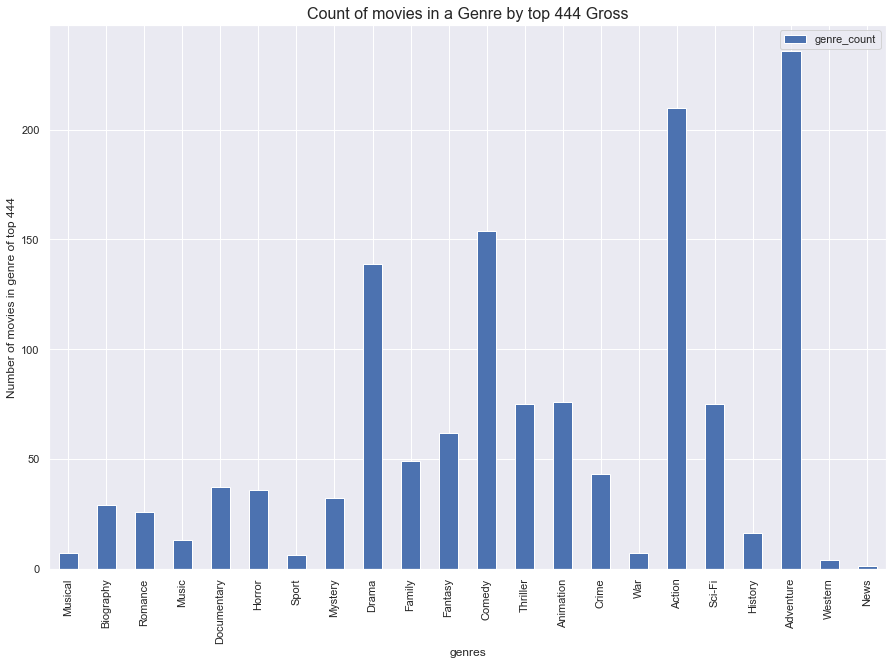

In [52]:
sns.set(style="darkgrid")

sns.color_palette("rocket")

sns.set(rc = {'figure.figsize':(15,10)})

#create stacked bar chart
plot = top_genres.set_index('genre').plot(kind='bar', y='genre_count', stacked=False)

#add overall title
plt.title('Count of movies in a Genre by top 444 Gross', fontsize=16)

#update y axis from scientific notation
plot.ticklabel_format(style='plain', scilimits=(0,20), axis='y')

#add axis titles
plt.xlabel('genres')
plt.ylabel('Number of movies in genre of top 444')

now, with a plot of the count of genres, update the dataframe to sort based on ROI

In [47]:
top_genres = top_genres.sort_values(by='genre_avg_roi',
                   ascending=False,
                   inplace=False)

Text(0, 0.5, '% ROI')

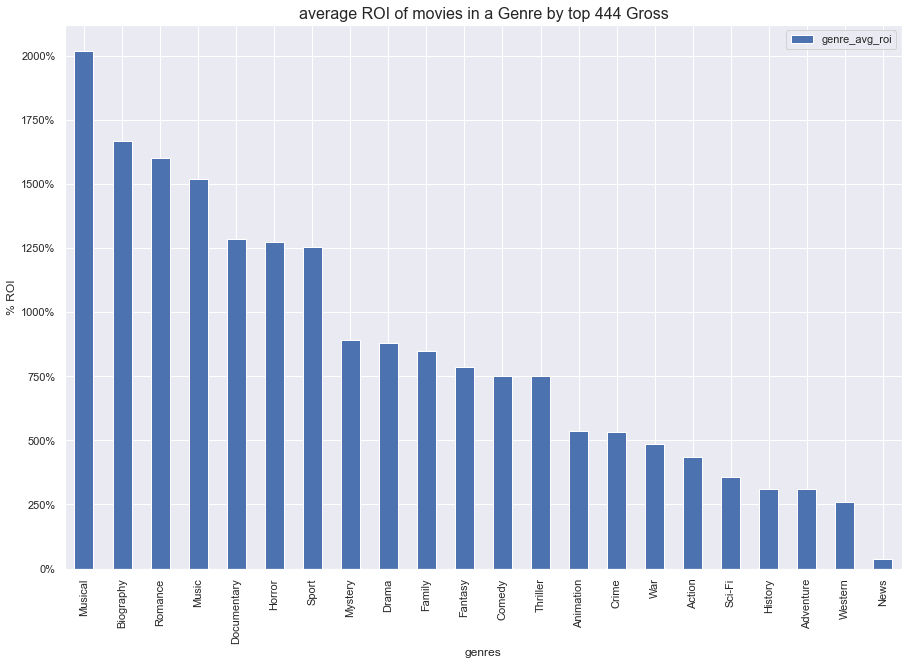

In [48]:
sns.set(style="darkgrid")

sns.color_palette("rocket")

sns.set(rc = {'figure.figsize':(15,10)})

#create stacked bar chart
plot2 = top_genres.set_index('genre').plot(kind='bar', y='genre_avg_roi', stacked=False)

#add overall title
plt.title('average ROI of movies in a Genre by top 444 Gross', fontsize=16)

#update y axis from scientific notation
plot2.yaxis.set_major_formatter(mtick.PercentFormatter())

#add axis titles
plt.xlabel('genres')
plt.ylabel('% ROI')

# Findings

Interestingly, many movies with a worldwide gross that would place them in the top 1000 don't necessarily have an incredibly large ROI.

For example, adventure and action movies may have an incredibly large amount of global revenue due to a large viewership, but producing a AAA Action movie is going to be very expensive.

If the studio wanted general appeal as a way to encourage viewers to seek out their movies, then adventure, action, comedies may be the way to go.

Another viewpoint would be to produce a movie in a genre that would lead to the best ROI. As a new studio, movies that can create a strong return may be more important to demonstrate the studio's viability to Mr. Gates.

If so, movies that don't require a large budget, like a musical, biography, or a romance may be the better option.

With these visualizations, it's important to note that they all had massive appeal, as they come from a dataset of films that did very well, so no matter the choice of genre, it's important to make a good film the public will enjoy. 

How you select your actors and your directors will play a very big role in how any movie in any genre will perform.